In [2]:
##mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import json
import os
import pandas as pd
import torch
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn.init as init
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [0]:
base_path = '/content/drive/My Drive/DL_exp/'

In [0]:
### custom dataset class for dataset. read the csv in __init__ . 
# input : csv file path
# output: returns (data,label)
class load_dataset(Dataset):
    def __init__(self, data_path):
        self.samples = pd.read_csv(data_path).values

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx,:-1] ,self.samples[idx,-1]
      
### Multilayer Perceptron Model
# input : number of features (input), hidden nodes list , number of classes
class MultilayerPerceptron(torch.nn.Module):
  
    def __init__(self,num_features,hidden_nodes_list,num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        num_hidden_layes = len(hidden_nodes_list)
        self.hidden = torch.nn.ModuleList()
        
        self.hidden.append(torch.nn.Linear(num_features, hidden_nodes_list[0]))
        for k in range(num_hidden_layes-1):
            self.hidden.append(torch.nn.Linear(hidden_nodes_list[k], hidden_nodes_list[k+1]))    
        self.hidden.append(torch.nn.Linear(hidden_nodes_list[num_hidden_layes-1], num_classes))
        
    # input : features
    # output: logits , probabilities
    def forward(self, x):
        out = x
        for layer in self.hidden[:-1]:
          out = layer(out)
          out = F.relu(out)

        logits = self.hidden[-1](out)
        probas = F.log_softmax(logits, dim=1)
        return logits, probas
      
### weight initialization function
# use : model.apply(init_weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    if initialisation_method=='xavier':
      init.xavier_uniform_(m.weight)
    if initialisation_method=='he':
      init.kaiming_uniform_(m.weight)
    m.bias.data.fill_(0.01)
    
### function to compute the accuracy
# input : model, data of type DataLoader
# output: cost (log loss), accuracy 
def compute_accuracy(net, data_loader):
    net.eval()
    cost, correct_pred, num_examples = 0, 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.float().to(device)
            targets = targets.long().to(device)
            logits, probas = net(features)
            cost += F.cross_entropy(logits, targets) * targets.size(0)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return cost/num_examples , correct_pred.float()/num_examples * 100

In [119]:
### Training of model
radius_of_sphere_or_inner_shell = 1                  
radius_of_outer_shell = 1.1
thickness_of_shell = 0
dim = 64       
data_dir = 'shell_shell_data_version1/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start_time = time.time()
          
file_name = 'train_in'+ str(radius_of_sphere_or_inner_shell) + '_out'+ str(radius_of_outer_shell) + '_t' + str(thickness_of_shell)+ '_' + str(dim) + 'dim.csv'

csv_path = base_path+data_dir+file_name
dataset = load_dataset(csv_path)
size = len(dataset)
train_dataloader = DataLoader(dataset, batch_size=size, shuffle=True)

t_h = h_nodes
t_i = 1000

#architecture
num_features  = next(iter(dataset))[0].shape[0]        # Input data dimention
# hidden_nodes_list   = [h_nodes]
hidden_nodes_list   = [math.ceil(h_nodes*0.1),math.floor(h_nodes*0.9)]                             # List of number of nodes at each hidden layer
num_classes   = 2                                      # The number of output classes. In this case, 0 and 1

# 'xavier' : Xavier Initialisation
# 'he' : He Initialisation
initialisation_method = 'xavier'

# 'sgd' : SGD (lr) 
# 'sgdwm' : SGD with Momentum (lr, momentum)
# 'adagrad' : AdaGrad
# 'adam' : Adam
# 'ngd' : Natural gradient descent
# 'l1' : L1 Regularisation
# 'l2' : L2 Regularisation
# 'pathnorm' : PathNorm Regularisation
# 'spectralnorm' : Spectral norm Regularisation
optimisation_method = 'sgdwm'  

# Hyperparameters
random_seed = t_i
learning_rate = 0.05
      
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features,hidden_nodes_list,num_classes)
model.apply(init_weights)
model = model.to(device)

if optimisation_method=='sgd' or optimisation_method=='ngd':
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
if optimisation_method=='sgdwm':
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
if optimisation_method=='adagrad':
  optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
if optimisation_method=='adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)

epoch = 0

with torch.set_grad_enabled(False):
  cost,best_acc = compute_accuracy(model, train_dataloader)

count = 1
prev_acc=best_acc
best_epoch = epoch
best_cost = cost

while True:
    model.train()
    for batch_idx, (features, targets) in enumerate(train_dataloader):

        features = features.float().to(device)
        targets = targets.long().to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()


    with torch.set_grad_enabled(False):
        cost,acc = compute_accuracy(model, train_dataloader)
        
    epoch+=1
    
    # Stopping conditions
    if prev_acc==acc:
      count+=1
    else:
      prev_acc=acc
      count=1
    if (epoch>50 and best_acc-acc>=5) or count==20 or epoch==400:
    # if (epoch>50 and best_acc-acc>=5) or epoch==400:
      break
    if acc>best_acc:
      best_acc=acc
      best_epoch = epoch
      best_cost = cost

print('Epoch: %03d | Accuracy: %.2f%% | Cost: %.4f' % (epoch,acc,cost))
print('Epoch: %03d | Accuracy: %.2f%% | Cost: %.4f' % (best_epoch,best_acc,best_cost))

Epoch: 234 | Accuracy: 100.00% | Cost: 0.0695
Epoch: 215 | Accuracy: 100.00% | Cost: 0.1207


In [116]:
# Transfer Learning
copy_model_dict = model.state_dict()
fl_weight = copy_model_dict['hidden.0.weight'].cpu().numpy()
fl_bias = copy_model_dict['hidden.0.bias'].cpu().numpy()
sl_weight = copy_model_dict['hidden.1.weight'].cpu().numpy()
sl_bias = copy_model_dict['hidden.1.bias'].cpu().numpy()
tl_weight = copy_model_dict['hidden.2.weight'].cpu().numpy()
tl_bias = copy_model_dict['hidden.2.bias'].cpu().numpy()
# print(fl_weight.shape,fl_bias.shape,sl_weight.shape,sl_bias.shape,tl_weight.shape,tl_bias.shape)

radius_of_sphere_or_inner_shell = 2              
radius_of_outer_shell = 2.1
thickness_of_shell = 0
dim = 64         
data_dir = 'shell_shell_data_version1/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start_time = time.time()
          
file_name = 'train_in'+ str(radius_of_sphere_or_inner_shell) + '_out'+ str(radius_of_outer_shell) + '_t' + str(thickness_of_shell)+ '_' + str(dim) + 'dim.csv'

csv_path = base_path+data_dir+file_name
data = pd.read_csv(csv_path).values
X = data[:,:-1]
y = data[:,-1]

X_fl = np.dot(X,np.transpose(fl_weight))+fl_bias
X_afl = np.maximum(0,X_fl)
X_sl = np.dot(X_afl,np.transpose(sl_weight))+sl_bias
X_asl = np.maximum(0,X_sl)
logits = np.dot(X_asl,np.transpose(tl_weight))+tl_bias
probas = np.exp(logits)/np.sum(np.exp(logits))
predicted_labels = np.argmax(probas, axis=1)
num_examples = y.shape[0]
correct_pred = (predicted_labels == y).sum()
print(correct_pred/num_examples * 100)

input_X = X_fl

lm = linear_model.SGDClassifier(loss='log',max_iter=1000, tol=1e-5,random_state=10,learning_rate='constant',eta0=0.005)
lm.fit(input_X, y)
y_lm = lm.predict(input_X)
print (metrics.accuracy_score(y, y_lm)*100)

svm = LinearSVC(C=1,random_state=0, tol=1e-5)
svm.fit(input_X, y)
y_svm = svm.predict(input_X)
print (metrics.accuracy_score(y, y_svm)*100)

52.6
60.8
63.800000000000004


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[tensor(100., device='cuda:0'), tensor(100., device='cuda:0'), tensor(100., device='cuda:0'), tensor(100., device='cuda:0'), tensor(100., device='cuda:0'), tensor(100., device='cuda:0'), tensor(100., device='cuda:0'), tensor(100., device='cuda:0'), tensor(100., device='cuda:0')]
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
[51.800000000000004, 51.800000000000004, 51.800000000000004, 51.800000000000004, 51.800000000000004, 51.800000000000004, 51.800000000000004, 51.800000000000004, 51.800000000000004]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[49.4, 51.0, 50.0, 50.6, 50.0, 50.0, 50.4, 49.8, 49.6]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


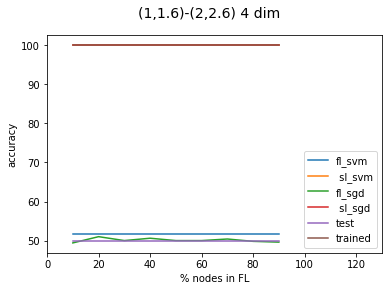

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Data for training
radius_of_sphere_or_inner_shell = 1                  
radius_of_outer_shell = 1.6
thickness_of_shell = 0
dim = 4       
data_dir = 'shell_shell_data_version1/'
         
file_name = 'train_in'+ str(radius_of_sphere_or_inner_shell) + '_out'+ str(radius_of_outer_shell) + '_t' + str(thickness_of_shell)+ '_' + str(dim) + 'dim.csv'
csv_path = base_path+data_dir+file_name
dataset = load_dataset(csv_path)
size = len(dataset)
train_dataloader = DataLoader(dataset, batch_size=size, shuffle=True)

## Data for testing
radius_of_sphere_or_inner_shell = 2             
radius_of_outer_shell = 2.6
          
file_name = 'train_in'+ str(radius_of_sphere_or_inner_shell) + '_out'+ str(radius_of_outer_shell) + '_t' + str(thickness_of_shell)+ '_' + str(dim) + 'dim.csv'
csv_path = base_path+data_dir+file_name
data = pd.read_csv(csv_path).values
X = data[:,:-1]
y = data[:,-1]

## 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h_nodes = 512
fraction = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
trained = []
test = []
svc_fl = []
svc_sl = []
sgd_fl = []
sgd_sl = []

for frac in fraction:
  #architecture
  num_features  = next(iter(dataset))[0].shape[0]        # Input data dimention
  hidden_nodes_list   = [math.ceil(h_nodes*frac),math.floor(h_nodes*(1-frac))]     # List of number of nodes at each hidden layer
  num_classes   = 2                                      # The number of output classes. In this case, 0 and 1

  # 'xavier' : Xavier Initialisation
  # 'he' : He Initialisation
  initialisation_method = 'xavier'

  # 'sgd' : SGD (lr) 
  # 'sgdwm' : SGD with Momentum (lr, momentum)
  # 'adagrad' : AdaGrad
  # 'adam' : Adam
  # 'ngd' : Natural gradient descent
  # 'l1' : L1 Regularisation
  # 'l2' : L2 Regularisation
  # 'pathnorm' : PathNorm Regularisation
  # 'spectralnorm' : Spectral norm Regularisation
  optimisation_method = 'sgdwm'  

  # Hyperparameters
  random_seed = 1000
  learning_rate = 0.05
        
  torch.manual_seed(random_seed)
  model = MultilayerPerceptron(num_features,hidden_nodes_list,num_classes)
  model.apply(init_weights)
  model = model.to(device)

  if optimisation_method=='sgd' or optimisation_method=='ngd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  if optimisation_method=='sgdwm':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  if optimisation_method=='adagrad':
    optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
  if optimisation_method=='adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)

  epoch = 0

  with torch.set_grad_enabled(False):
    cost,best_acc = compute_accuracy(model, train_dataloader)

  count = 1
  prev_acc=best_acc
  best_epoch = epoch
  best_cost = cost

  while True:
      model.train()
      for batch_idx, (features, targets) in enumerate(train_dataloader):

          features = features.float().to(device)
          targets = targets.long().to(device)

          ### FORWARD AND BACK PROP
          logits, probas = model(features)
          cost = F.cross_entropy(logits, targets)
          optimizer.zero_grad()

          cost.backward()

          ### UPDATE MODEL PARAMETERS
          optimizer.step()


      with torch.set_grad_enabled(False):
          cost,acc = compute_accuracy(model, train_dataloader)
          
      epoch+=1
      
      # Stopping conditions
      if prev_acc==acc:
        count+=1
      else:
        prev_acc=acc
        count=1
      if (epoch>50 and best_acc-acc>=5) or count==20 or epoch==400:
      # if (epoch>50 and best_acc-acc>=5) or epoch==400:
        break
      if acc>best_acc:
        best_acc=acc
        best_epoch = epoch
        best_cost = cost

  # print('Epoch: %03d | Accuracy: %.2f%% | Cost: %.4f' % (best_epoch,best_acc,best_cost))
  trained.append(best_acc)

  # Transfer Learning
  copy_model_dict = model.state_dict()
  fl_weight = copy_model_dict['hidden.0.weight'].cpu().numpy()
  fl_bias = copy_model_dict['hidden.0.bias'].cpu().numpy()
  sl_weight = copy_model_dict['hidden.1.weight'].cpu().numpy()
  sl_bias = copy_model_dict['hidden.1.bias'].cpu().numpy()
  tl_weight = copy_model_dict['hidden.2.weight'].cpu().numpy()
  tl_bias = copy_model_dict['hidden.2.bias'].cpu().numpy()

  X_fl = np.dot(X,np.transpose(fl_weight))+fl_bias
  X_afl = np.maximum(0,X_fl)
  X_sl = np.dot(X_afl,np.transpose(sl_weight))+sl_bias
  X_asl = np.maximum(0,X_sl)
  logits = np.dot(X_asl,np.transpose(tl_weight))+tl_bias
  probas = np.exp(logits)/np.sum(np.exp(logits))
  predicted_labels = np.argmax(probas, axis=1)
  num_examples = y.shape[0]
  correct_pred = (predicted_labels == y).sum()
  test.append(correct_pred/num_examples * 100)

  input_X = X_fl

  lm = linear_model.SGDClassifier(loss='log',max_iter=1000, tol=1e-5,random_state=10,learning_rate='constant',eta0=0.005)
  lm.fit(input_X, y)
  y_lm = lm.predict(input_X)
  sgd_fl.append(metrics.accuracy_score(y, y_lm)*100)

  svm = LinearSVC(C=1,random_state=0, tol=1e-5)
  svm.fit(input_X, y)
  y_svm = svm.predict(input_X)
  svc_fl.append(metrics.accuracy_score(y, y_svm)*100)

  input_X = X_sl

  lm = linear_model.SGDClassifier(loss='log',max_iter=1000, tol=1e-5,random_state=10,learning_rate='constant',eta0=0.005)
  lm.fit(input_X, y)
  y_lm = lm.predict(input_X)
  sgd_sl.append(metrics.accuracy_score(y, y_lm)*100)

  svm = LinearSVC(C=1,random_state=0, tol=1e-5)
  svm.fit(input_X, y)
  y_svm = svm.predict(input_X)
  svc_sl.append(metrics.accuracy_score(y, y_svm)*100)
print(trained)
print(test)
print(svc_fl)
print(svc_sl)
print(sgd_fl)
print(sgd_sl)

xaxis = [int(f*100) for f in fraction]
fig = plt.figure()
plt.plot(xaxis,svc_fl,label='fl_svm')
plt.plot(xaxis,svc_sl,label=' sl_svm')
plt.plot(xaxis,sgd_fl,label='fl_sgd')
plt.plot(xaxis,sgd_sl,label=' sl_sgd')
plt.plot(xaxis,test,label='test')
plt.plot(xaxis,trained,label='trained')
axes = plt.gca()
axes.set_xlim([0,130])
plt.legend(loc='lower right')
plt.xlabel('% nodes in FL')
plt.ylabel('accuracy')
fig.suptitle('(1,1.6)-(2,2.6) 4 dim', fontsize=14)
fig.savefig(base_path+'result/4.jpg')